In [7]:
import os
import shutil

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import Audio
from matplotlib.pyplot import imshow
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight

import librosa
from librosa import display
import pylab
from matplotlib import cm

import keras
from keras import layers
from keras import models
from keras import layers
from keras import optimizers
from keras import callbacks
from keras import regularizers
from keras import models

from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Flatten
from keras.models import Model

%matplotlib inline

In [8]:
# Seed initialization for random number generator to ensure reproducibility
seed = 12
np.random.seed(seed)

# Define the relative path to the data
path = "../"

# Define the path to the audio files and image files stored according to genres
path_audio_files = path + "Data/genres_original/"
path_image_files = path + "Data/images_original/"

# Parameters related to Fast Fourier Transform (FFT) and hop length for audio processing
hop_length = 512 # Number of samples between successive frames
n_fft = 2048  # Number of FFTs (Fast Fourier Transforms) per frame

# Dictionary to map the genre to an integer for encoding
genre_dict = {"blues": 0, "classical": 1, "country": 2, "disco": 3,
              "hiphop": 4, "jazz": 5, "metal": 6, "pop": 7, "reggae": 8, "rock": 9}
genre_list = list(genre_dict.keys())

## File paths for audio and image files

In [9]:
# Get all audio file paths in gtzan dataset
audio_files = []
for subdir in sorted(os.listdir(path_audio_files)):
    subdir_path = os.path.join(path_audio_files, subdir)
    if os.path.isdir(subdir_path):
        files = sorted(os.listdir(subdir_path))
        for file in files:
            audio_files.append(os.path.join(subdir_path, file))

print('Number of audio files:', len(audio_files))

Number of audio files: 999


In [10]:
# Get all image file paths in gtzan dataset
image_files = []
for subdir in sorted(os.listdir(path_image_files)):
    subdir_path = os.path.join(path_image_files, subdir)
    if os.path.isdir(subdir_path):
        files = sorted(os.listdir(subdir_path))
        for file in files:
            image_files.append(os.path.join(subdir_path, file))

print('Number of image files:', len(image_files))

Number of image files: 999


In [11]:
IMG_DIR = path_image_files
IMG_HEIGHT = 288
IMG_WIDTH = 432

## Data cleaning

In [12]:
# Get list of indices of files that are corrupted
bad_idxs = []
for i, file_path in enumerate(audio_files):
    try:
        y, sr = librosa.load(file_path, sr=22050)
    except Exception as e:
        bad_idxs.append(i)
        continue

# Remove corrupted files from audio_files and image_files
remove_image_files = [audio_files[idx][:-4] + ".png" for idx in bad_idxs]

audio_files = [file for i, file in enumerate(audio_files) if i not in bad_idxs]
image_files = [file for file in image_files if file not in remove_image_files]
print(len(audio_files), len(image_files))
assert len(audio_files) == len(image_files)

## Generate all spectrograms

In [13]:
# IMG_DIR = './spectrogram_images/'
# IMG_HEIGHT = 360
# IMG_WIDTH = 360

# if os.path.exists(IMG_DIR):
#     shutil.rmtree(IMG_DIR)
# os.makedirs(IMG_DIR)

In [14]:
# for i, file_path in enumerate(audio_files):
#     try:
#         # Read wav-file
#         y, sr = librosa.load(file_path, sr=22050)
        
#         # Compute spectrogram
#         M = librosa.feature.melspectrogram(y=y, sr=sr, 
#                                            fmax=sr/2,        # Maximum frequency to be used on the on the MEL scale
#                                            n_fft=2048, 
#                                            hop_length=512, 
#                                            n_mels=96,        # Set as per the Google Large-scale audio CNN paper
#                                            power=2)          # Power = 2 refers to squared amplitude
        
#         # Power in DB
#         log_power = librosa.power_to_db(M, ref=np.max)       # Covert to dB (log) scale
        
#         # Plotting the spectrogram
#         pylab.figure(figsize=(5,5))
#         pylab.axis('off') 
#         pylab.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[]) # Remove the white edge
#         librosa.display.specshow(log_power, cmap=cm.jet)
#         pylab.savefig(IMG_DIR + os.path.basename(file_path)[:-4] + '.jpg', bbox_inches=None, pad_inches=0)
#         pylab.close()

#     except Exception as e:
#         print(file_path, e)
#         pass

## Plot some spectrograms

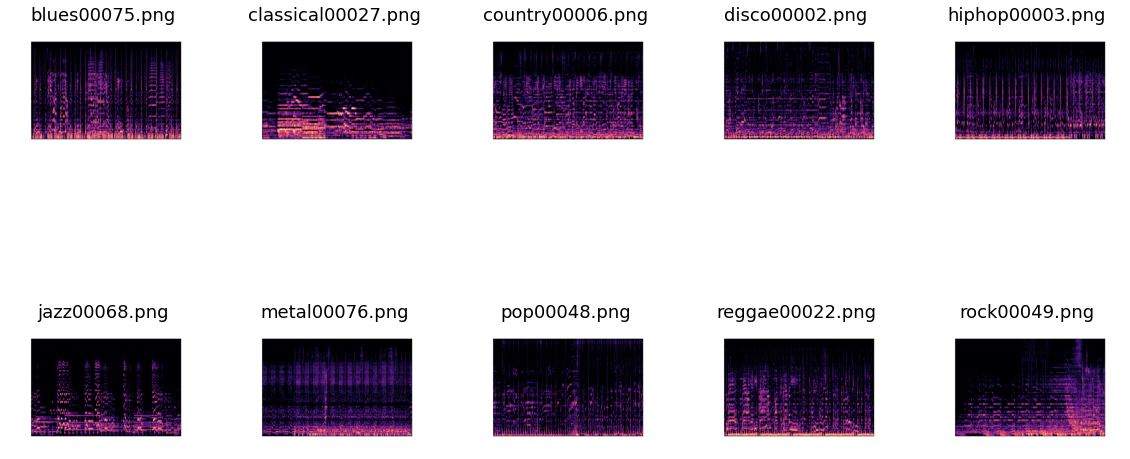

In [15]:
# Randomly select 1 spectrogram from each category for plotting
sample_files = []
for subdir in sorted(os.listdir(IMG_DIR)):
    subdir_path = os.path.join(IMG_DIR, subdir)
    if os.path.isdir(subdir_path):
        files = sorted(os.listdir(subdir_path))
        sample_files.append(os.path.join(subdir_path, np.random.choice(files)))

f, axarr = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(20,10))
coordinates = [(0,0), (0,1), (0,2), (0,3), (0,4), (1,0), (1,1), (1,2), (1,3), (1,4)]

for i, file in enumerate(sample_files):
    im = Image.open(file)
    # im = im.resize((IMG_WIDTH, IMG_HEIGHT), resample = Image.ANTIALIAS)
    axarr[coordinates[i]].imshow(np.asarray(im))
    axarr[coordinates[i]].axis('off')
    axarr[coordinates[i]].set_title(file.split('/')[-1], fontsize=18)

## VGG CNN Model

In [16]:
NUM_CLASSES = 10
NUM_EPOCHS = 10
BATCH_SIZE = 25
L2_LAMBDA = 0.001

### Pre-processing

In [17]:
# Get list of labels for all files
label_array = []
for file in audio_files:
    genre = file.split('/')[3]
    label_array.append(genre_dict[genre])

# Get class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(label_array), y=label_array)
class_weight_dict = dict(enumerate(class_weights))

# Train-val-test split of files
train_files, test_files, train_labels, test_labels = train_test_split(image_files, label_array, random_state=10, test_size=0.1)

# Among the test files, keep half for validation
val_files, test_files, val_labels, test_labels = train_test_split(test_files, test_labels, random_state=10, test_size=0.5)

### Convolution layer

In [18]:
# Define the input shape of the images
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)

# Load the pre-trained VGG16 model
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the layers of the pre-trained model
for layer in vgg_model.layers:
    layer.trainable = False

vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 288, 432, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 288, 432, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 288, 432, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 144, 216, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 144, 216, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 144, 216, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 72, 108, 128)      0     

### Fully connected layer

In [19]:
# Add a new fully connected layer on top of the pre-trained model
x = Flatten()(vgg_model.output)
x = Dense(1024, activation='relu')(x)
x = Dense(NUM_CLASSES, activation='softmax')(x)

In [20]:
# Create a new model with the pre-trained VGG16 as the base and the new fully connected layer on top
model = Model(inputs=vgg_model.input, outputs=x)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Data generators

In [21]:
# Create data generators for training, validation, and testing
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(directory=IMG_DIR, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE, class_mode='categorical', subset='training')
val_generator = val_datagen.flow_from_directory(directory=IMG_DIR, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE, class_mode='categorical', subset='validation')
test_generator = test_datagen.flow_from_directory(directory=IMG_DIR, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)

Found 999 images belonging to 10 classes.
Found 0 images belonging to 10 classes.
Found 999 images belonging to 10 classes.


### Model training and evaluation

In [22]:
# Train the model
history = model.fit(train_generator, epochs=NUM_EPOCHS, validation_data=val_generator, class_weight=class_weight_dict)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)

Epoch 1/10
40/40 [==============================] - 318s 8s/step - loss: 7.6607 - accuracy: 0.2583
Epoch 2/10
40/40 [==============================] - 343s 9s/step - loss: 1.4551 - accuracy: 0.5055
Epoch 3/10
40/40 [==============================] - 325s 8s/step - loss: 1.2338 - accuracy: 0.5836
Epoch 4/10
40/40 [==============================] - 313s 8s/step - loss: 1.1518 - accuracy: 0.6466
Epoch 5/10
40/40 [==============================] - 314s 8s/step - loss: 0.9614 - accuracy: 0.6757
Epoch 6/10
40/40 [==============================] - 315s 8s/step - loss: 0.7993 - accuracy: 0.7467
Epoch 7/10
40/40 [==============================] - 315s 8s/step - loss: 0.7633 - accuracy: 0.7568
Epoch 8/10
40/40 [==============================] - 313s 8s/step - loss: 0.7162 - accuracy: 0.7748
Epoch 9/10
40/40 [==============================] - 313s 8s/step - loss: 0.6120 - accuracy: 0.7948
Epoch 10/10
40/40 [==============================] - 295s 7s/step - loss: 0.7138 - accuracy: 0.7477
Test accu

## Baseline CNN Model

In [26]:
baseline_model = models.Sequential()

# Convolutional Layer 1
baseline_model.add(layers.Conv2D(32, (3, 3), input_shape=(IMG_WIDTH, IMG_HEIGHT, 3), activation='relu', name='conv1'))
baseline_model.add(layers.MaxPooling2D(pool_size=(2, 2), name='maxpool1'))
baseline_model.add(layers.Dropout(0.25, name='dropout1'))

# Convolutional Layer 2
baseline_model.add(layers.Conv2D(64, (3, 3), activation='relu', name='conv2'))
baseline_model.add(layers.MaxPooling2D(pool_size=(2, 2), name='maxpool2'))
baseline_model.add(layers.Dropout(0.25, name='dropout2'))

# Convolutional Layer 3
baseline_model.add(layers.Conv2D(64, (3, 3), activation='relu', name='conv3'))
baseline_model.add(layers.MaxPooling2D(pool_size=(2, 2), name='maxpool3'))
baseline_model.add(layers.Dropout(0.25, name='dropout3'))

# Flatten the feature maps
baseline_model.add(layers.Flatten(name='flatten'))

# Fully connected layers
baseline_model.add(layers.Dense(128, activation='relu', name='dense1'))
baseline_model.add(layers.Dropout(0.5, name='dropout4'))

# Output layer
baseline_model.add(layers.Dense(NUM_CLASSES, activation='softmax', name='output'))

# Print model summary
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 430, 286, 32)      896       
                                                                 
 maxpool1 (MaxPooling2D)     (None, 215, 143, 32)      0         
                                                                 
 dropout1 (Dropout)          (None, 215, 143, 32)      0         
                                                                 
 conv2 (Conv2D)              (None, 213, 141, 64)      18496     
                                                                 
 maxpool2 (MaxPooling2D)     (None, 106, 70, 64)       0         
                                                                 
 dropout2 (Dropout)          (None, 106, 70, 64)       0         
                                                                 
 conv3 (Conv2D)              (None, 104, 68, 64)       3

In [27]:
# Compile the model
baseline_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
baseline_history = baseline_model.fit(train_generator, epochs=NUM_EPOCHS, validation_data=val_generator, class_weight=class_weight_dict)

# Evaluate the model on the test set
test_loss, test_acc = baseline_model.evaluate(test_generator)
print('Baseline test accuracy:', test_acc)

Epoch 1/10
40/40 [==============================] - 43s 1s/step - loss: 2.6859 - accuracy: 0.0911
Epoch 2/10
40/40 [==============================] - 43s 1s/step - loss: 2.3028 - accuracy: 0.0771
Epoch 3/10
40/40 [==============================] - 44s 1s/step - loss: 2.3015 - accuracy: 0.1091
Epoch 4/10
40/40 [==============================] - 47s 1s/step - loss: 2.2674 - accuracy: 0.1361
Epoch 5/10
40/40 [==============================] - 47s 1s/step - loss: 2.1435 - accuracy: 0.1952
Epoch 6/10
40/40 [==============================] - 49s 1s/step - loss: 2.0272 - accuracy: 0.2643
Epoch 7/10
40/40 [==============================] - 46s 1s/step - loss: 1.9260 - accuracy: 0.3313
Epoch 8/10
40/40 [==============================] - 46s 1s/step - loss: 1.8798 - accuracy: 0.3504
Epoch 9/10
40/40 [==============================] - 47s 1s/step - loss: 1.7428 - accuracy: 0.3954
Epoch 10/10
40/40 [==============================] - 11s 263ms/step - loss: 1.3454 - accuracy: 0.5195
Baseline test ac